In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
from torchvision.transforms import functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [ ]:
annotation_file='/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/annotations/train.json'

with open(annotation_file) as f:
    data = json.load(f)
    print(data.keys())
    annotations = data['annotations']

dict_keys(['images', 'type', 'annotations', 'categories'])


In [ ]:
# Print out the annotation file structure
with open(annotation_file) as f:
    data = json.load(f)

    print("Type:", data['type'])

    print("\nImages key structure:")
    for img in data['images'][:2]:
        print(img)

    print("\nAnnotations key structure:")
    for ann in data['annotations'][:2]:
        print(ann)

    print("\nCategories key structure:")
    for cat in data['categories']:
        print(cat)

Type: instances

Images key structure:
{'file_name': '_semantic', 'height': 380, 'width': 640, 'id': '_semantic'}
{'file_name': '_semantic', 'height': 380, 'width': 640, 'id': '_semantic'}

Annotations key structure:
{'area': 380, 'iscrowd': 0, 'bbox': [385, 175, 20, 19], 'category_id': 5, 'ignore': 0, 'segmentation': [], 'image_id': '001500', 'id': 1}
{'area': 150, 'iscrowd': 0, 'bbox': [361, 161, 6, 25], 'category_id': 4, 'ignore': 0, 'segmentation': [], 'image_id': '_semantic', 'id': 2}

Categories key structure:
{'supercategory': 'none', 'id': 1, 'name': 'vehicle'}
{'supercategory': 'none', 'id': 2, 'name': 'bike'}
{'supercategory': 'none', 'id': 3, 'name': 'motobike'}
{'supercategory': 'none', 'id': 4, 'name': 'traffic_light'}
{'supercategory': 'none', 'id': 5, 'name': 'traffic_sign'}


In [ ]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            image = TF.hflip(image)
            w, h = image.width, image.height
            if "boxes" in target:
                boxes = target["boxes"]
                xmin = w - boxes[:, 2]
                xmax = w - boxes[:, 0]
                boxes[:, 0] = xmin
                boxes[:, 2] = xmax
                target["boxes"] = boxes
        return image, target

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, annotation_file, img_dir, label_map, transform=None):
        with open(annotation_file) as f:
            data = json.load(f)
            self.images = [img for img in data['images'] if img['file_name'] != '_semantic']
            self.img_to_annotations = {}
            for image in self.images:
                self.img_to_annotations[image['id']] = []
            for ann in data['annotations']:
                if ann['image_id'] in self.img_to_annotations:
                    self.img_to_annotations[ann['image_id']].append(ann)

            self.label_map = {cat['id']: label_map[cat['name']] for cat in data['categories']}
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def apply_transform(self, image, target):
        if self.transform is not None:
            image, target = self.transform(image, target)
        return image, target

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_id = image_info['id']
        img_path = os.path.join(self.img_dir, image_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        annotations = self.img_to_annotations.get(image_id, [])

        boxes = []
        labels = []
        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_map[ann['category_id']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        # Apply transformations
        image, target = self.apply_transform(image, target)

        image = TF.to_tensor(image)

        return image, target

transformations = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    return images, list(targets)



# Use the dataset
dataset = CustomDataset(
    annotation_file='/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/annotations/train.json',
    img_dir='/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images/train',
    label_map=label_map,
    transform=transformations
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
# Check the annotations extracted from original data
with open('/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/annotations/train.json') as f:
    data = json.load(f)

image_id_to_check = "017760"
annotations_for_image = [ann for ann in data['annotations'] if ann['image_id'] == image_id_to_check]

for ann in annotations_for_image:
    print(ann)

# Check for any unexpected or duplicate annotations
unique_ids = set()
duplicates = []
for ann in annotations_for_image:
    if ann['id'] in unique_ids:
        duplicates.append(ann)
    unique_ids.add(ann['id'])

if duplicates:
    print("Duplicate annotations found:")
    for dup in duplicates:
        print(dup)
else:
    print("No duplicate annotations found for image_id:", image_id_to_check)

{'area': 2592, 'iscrowd': 0, 'bbox': [146, 191, 81, 32], 'category_id': 1, 'ignore': 0, 'segmentation': [], 'image_id': '017760', 'id': 1628}
{'area': 78, 'iscrowd': 0, 'bbox': [353, 128, 6, 13], 'category_id': 4, 'ignore': 0, 'segmentation': [], 'image_id': '017760', 'id': 1629}
{'area': 78, 'iscrowd': 0, 'bbox': [397, 124, 6, 13], 'category_id': 4, 'ignore': 0, 'segmentation': [], 'image_id': '017760', 'id': 1630}
{'area': 84, 'iscrowd': 0, 'bbox': [440, 120, 6, 14], 'category_id': 4, 'ignore': 0, 'segmentation': [], 'image_id': '017760', 'id': 1631}
{'area': 2592, 'iscrowd': 0, 'bbox': [110, 187, 81, 32], 'category_id': 1, 'ignore': 0, 'segmentation': [], 'image_id': '017760', 'id': 1632}
No duplicate annotations found for image_id: 017760


In [ ]:
import shutil
import os

# Define the paths
source_train_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train'
source_test_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test'
dest_test_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/test/image'
test_txt_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/image_sets/test.txt'

# Function to move files from source to destination
def move_file_if_exists(filename, source_paths, dest_path):
    for source_path in source_paths:
        source_file = os.path.join(source_path, filename)
        if os.path.isfile(source_file):
            shutil.move(source_file, os.path.join(dest_path, filename))
            print(f"Moved: {filename} from {source_path} to {dest_path}")
            return True
    print(f"File not found in source paths: {filename}")
    return False

# Read the test filenames from test.txt and append the appropriate extension
test_filenames = []
with open(test_txt_path, 'r') as file:
    for line in file:
        filename = line.strip() + '.png'
        test_filenames.append(filename)

In [ ]:
# Attempt to move each file from the train and val folders to the test folder
for filename in test_filenames:
    move_file_if_exists(filename, [source_train_path, source_test_path], dest_test_path)

print("File moving process completed.")

Moved: Town05_001920.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/test/image
Moved: Town05_001980.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/test/image
Moved: Town05_002040.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/test/image
Moved: Town05_002100.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/test/image
Moved: Town05_002160.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/test to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/ima

In [ ]:
# Define paths for train.txt and val.txt
train_txt_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/image_sets/train.txt'
val_txt_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/image_sets/val.txt'

# Destination paths for train and val images
dest_train_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images/train'
dest_val_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images/val'

# Function to process each dataset type
def process_dataset(txt_path, source_paths, dest_path):
    with open(txt_path, 'r') as file:
        filenames = [line.strip() + '.png' for line in file]
    for filename in filenames:
        move_file_if_exists(filename, source_paths, dest_path)

In [ ]:
source_train_yololabel_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/yolo_labels/train'
source_test_yololabel_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/yolo_labels/test'
dest_train_yololabel_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo_labels/train'
dest_test_yololabel_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo_labels/test'
dest_val_yololabel_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo_labels/val'

def process_dataset(txt_path, source_paths, dest_path):
    with open(txt_path, 'r') as file:
        filenames = [line.strip() + '.txt' for line in file]
    for filename in filenames:
        move_file_if_exists(filename, source_paths, dest_path)

# Attempt to move labels from the train and val folders to the train, test and val folder
process_dataset(train_txt_path, [source_train_yololabel_path, source_test_yololabel_path],dest_train_yololabel_path)
process_dataset(test_txt_path, [source_train_yololabel_path, source_test_yololabel_path], dest_test_yololabel_path)
process_dataset(val_txt_path, [source_train_yololabel_path, source_test_yololabel_path], dest_val_yololabel_path)

print("All yolo labels have been moved to their respective directories.")

In [ ]:
# Define paths for train.txt and val.txt
train_txt_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/image_sets/train.txt'
val_txt_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/image_sets/val.txt'

# Destination paths for train and val images
dest_train_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/train/image'
dest_val_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/val/image'


In [ ]:
# Attempt to move each file from the train and val folders to the train and val folder
process_dataset(train_txt_path, [source_train_path, source_test_path], dest_train_path)
process_dataset(val_txt_path, [source_train_path, source_test_path], dest_val_path)

print("All files have been moved to their respective directories.")

Moved: Town01_001020.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/train/image
Moved: Town01_001080.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/train/image
Moved: Town01_001140.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/train/image
Moved: Town01_001200.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images_yolo/train/image
Moved: Town01_001260.png from /content/drive/Shareddrives/Data255_Lab/Lab1/carla-object-detection-dataset/images/train to /content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_da

In [ ]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

base_dir = "/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/images"

def plot_random_images(image_dir, subset, num_images=3):
    subset_dir = os.path.join(image_dir, subset)
    images = []

    for root, dirs, files in os.walk(subset_dir):
        for file in files:
            if file.lower().endswith(('.png')):
                images.append(os.path.join(root, file))

    if len(images) < num_images:
        print(f"Not enough images.")
        num_images = len(images)

    selected_images = random.sample(images, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(selected_images, 1):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{subset.capitalize()} Image {i}")
    plt.show()

Displaying train images:


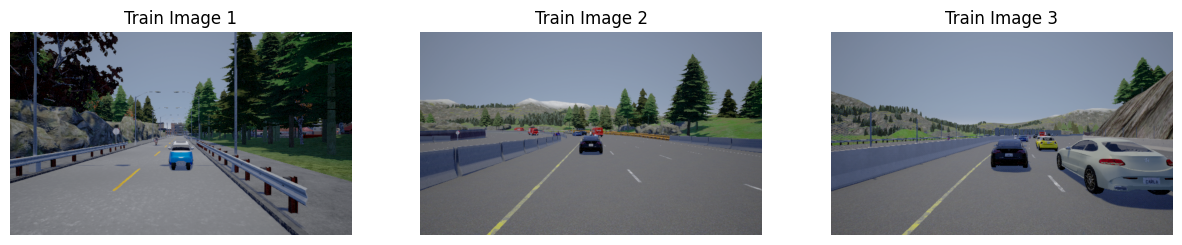

Displaying val images:


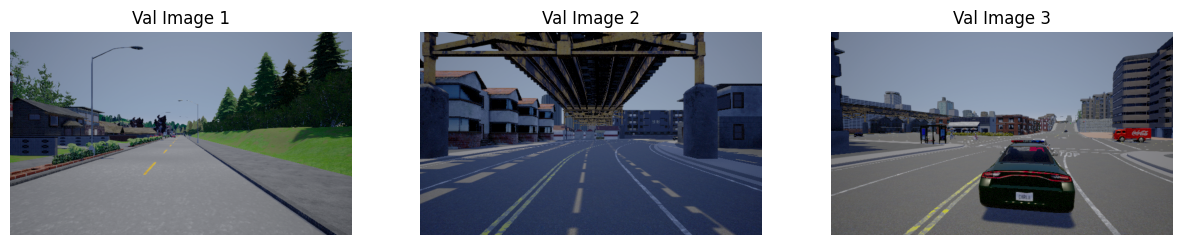

Displaying test images:


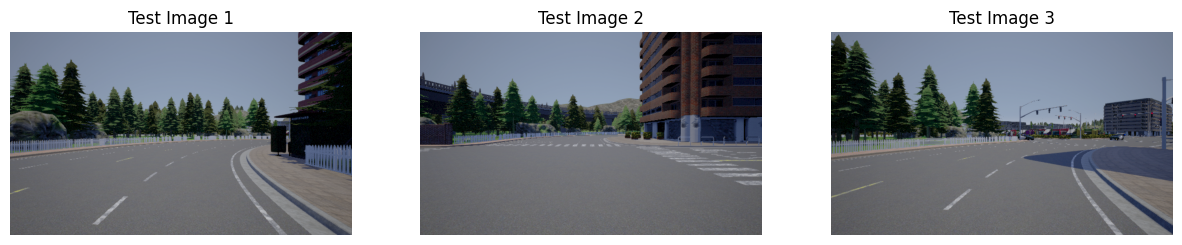

In [ ]:
# Plot 3 random images from each subset
for subset in ['train', 'val', 'test']:
    print(f"Displaying {subset} images:")
    plot_random_images(base_dir, subset)

# YOLO8

In [ ]:
!nvidia-smi

Mon Mar 25 22:42:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
pip install ultralytics==8.0.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
%cd /home/zeke/Downloads/part3_YOLO

/home/zeke/Downloads/part3_YOLO


In [ ]:
%cd /home/zeke/Downloads/part3_YOLO
!yolo task=detect mode=train model=yolov8s.pt data=/home/zeke/Downloads/part3_YOLO/data2.yaml epochs=25 imgsz=224 plots=True

/home/zeke/Downloads/images_yolo
Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11975MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/home/zeke/Downloads/images_yolo/data2.yaml, epochs=25, patience=50, batch=16, imgsz=224, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=Fal

In [ ]:
!ls runs/detect/train/

args.yaml					  P_curve.png	results.png
confusion_matrix.png				  PR_curve.png	weights
events.out.tfevents.1711164701.zeke-Z790.18184.0  R_curve.png
F1_curve.png					  results.csv


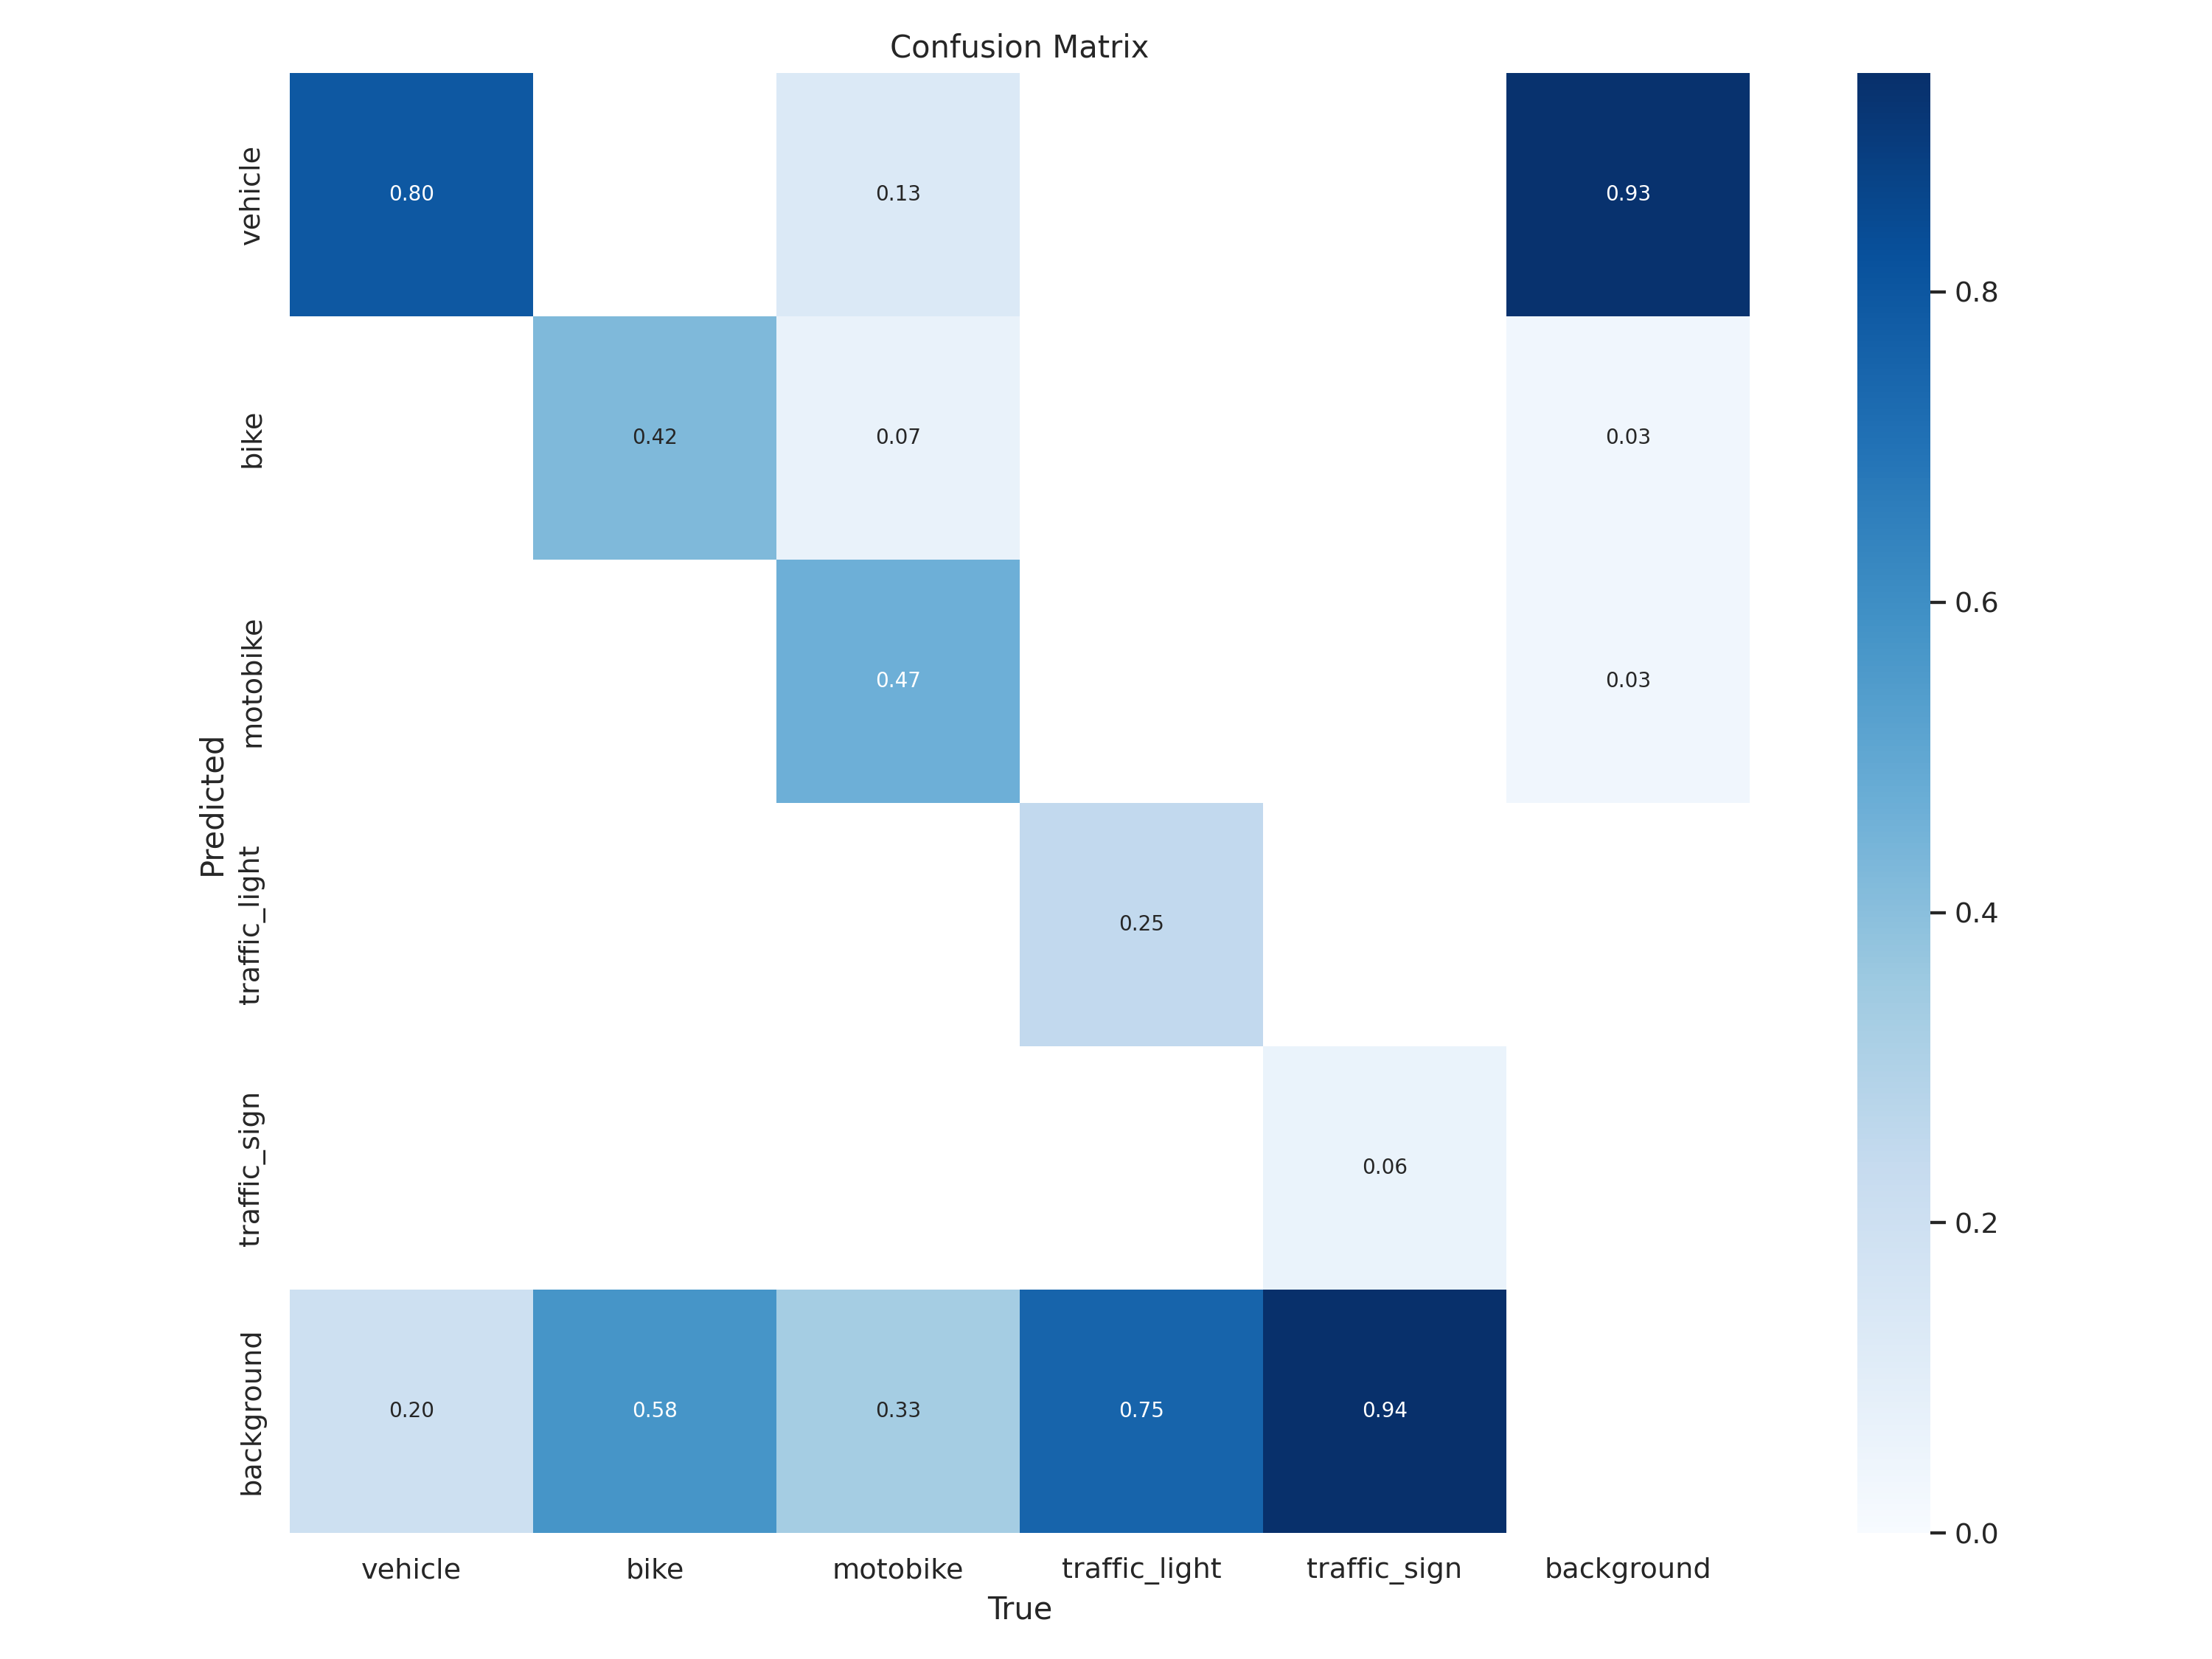

In [ ]:
Image(filename='/home/zeke/Downloads/part3_YOLO/runs/detect/train/confusion_matrix.png', width=600)

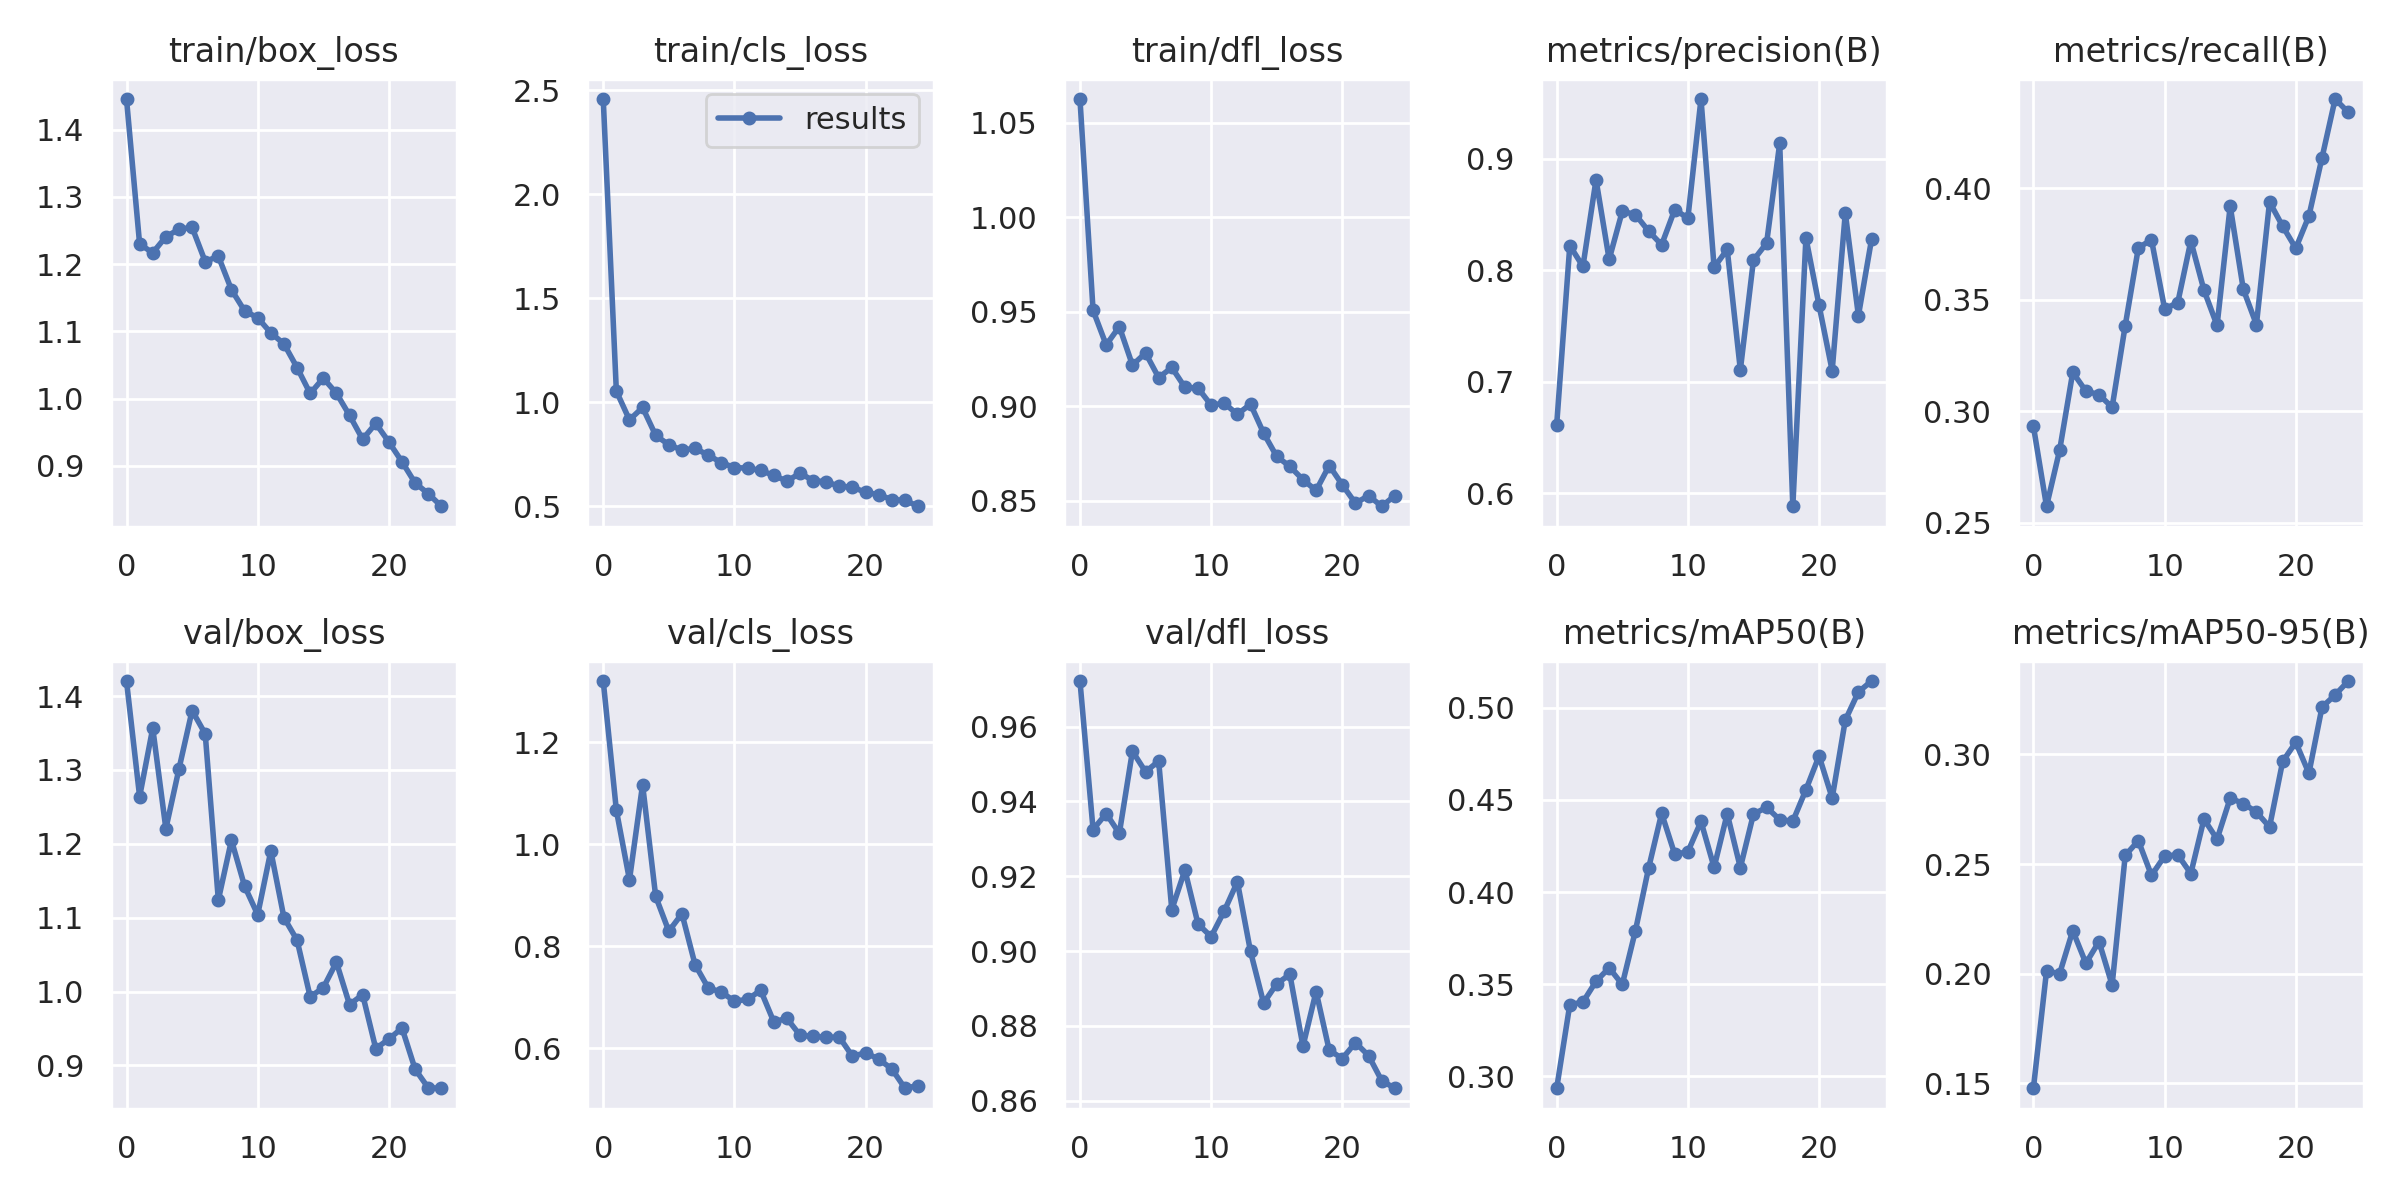

In [ ]:
Image(filename='/home/zeke/Downloads/part3_YOLO/runs/detect/train/results.png', width=600)

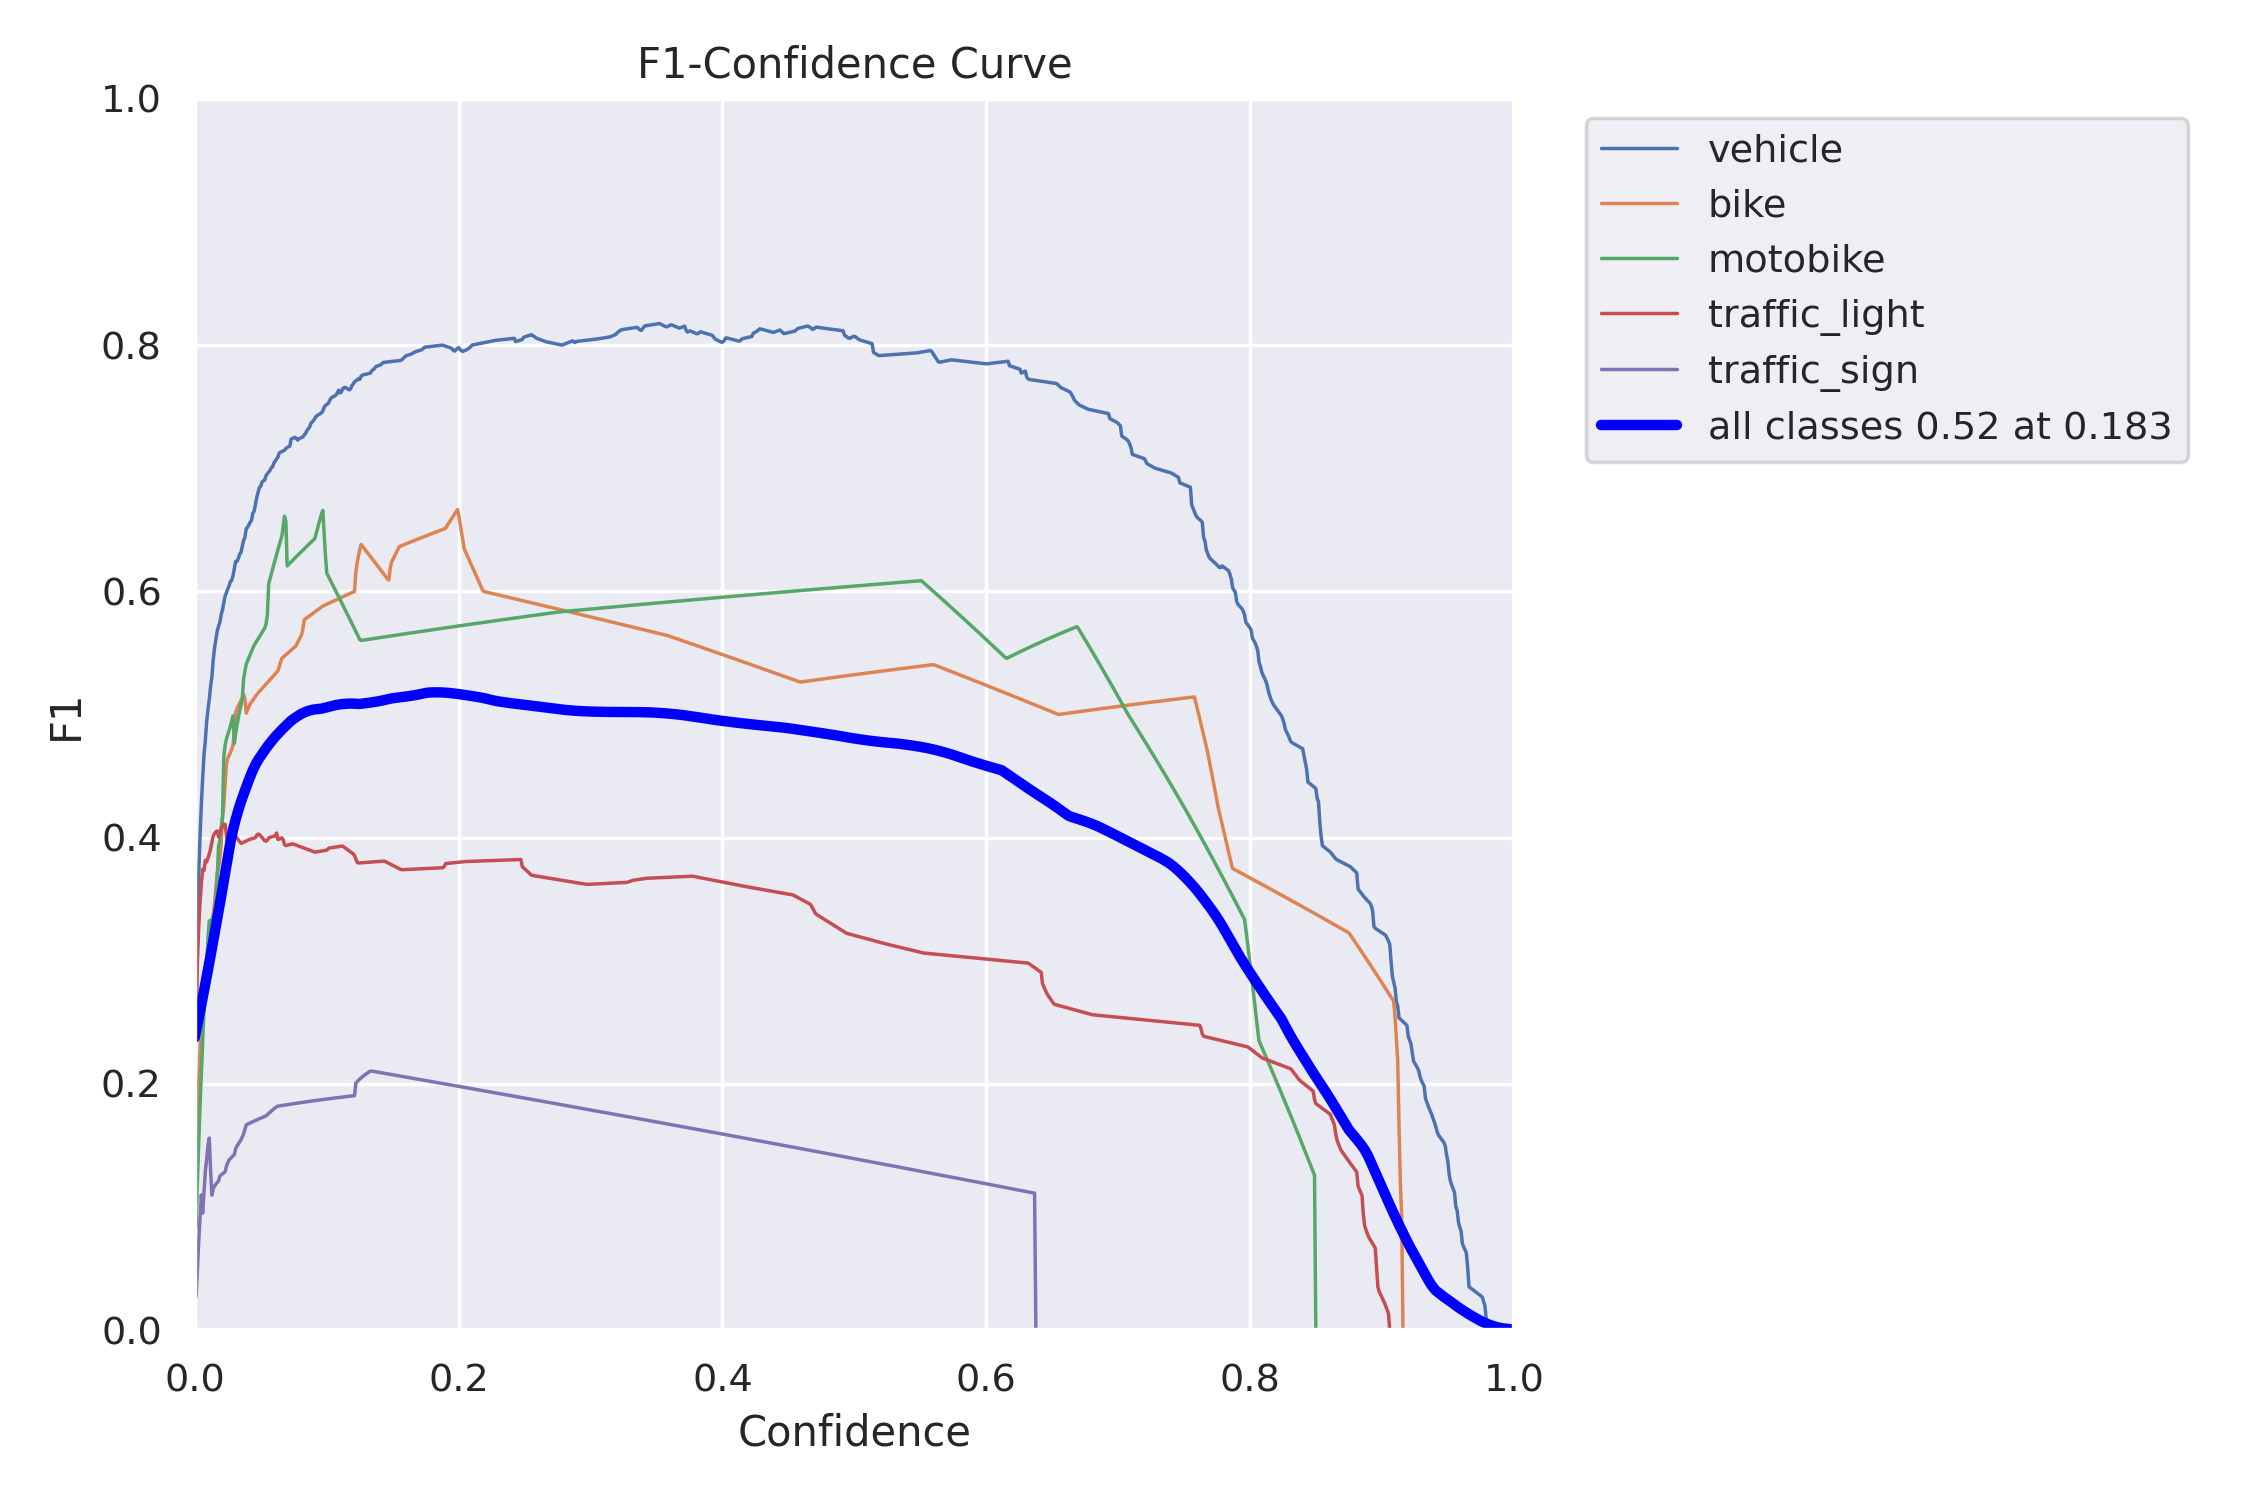

In [ ]:
Image(filename='/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/F1_curve.png', width=600)

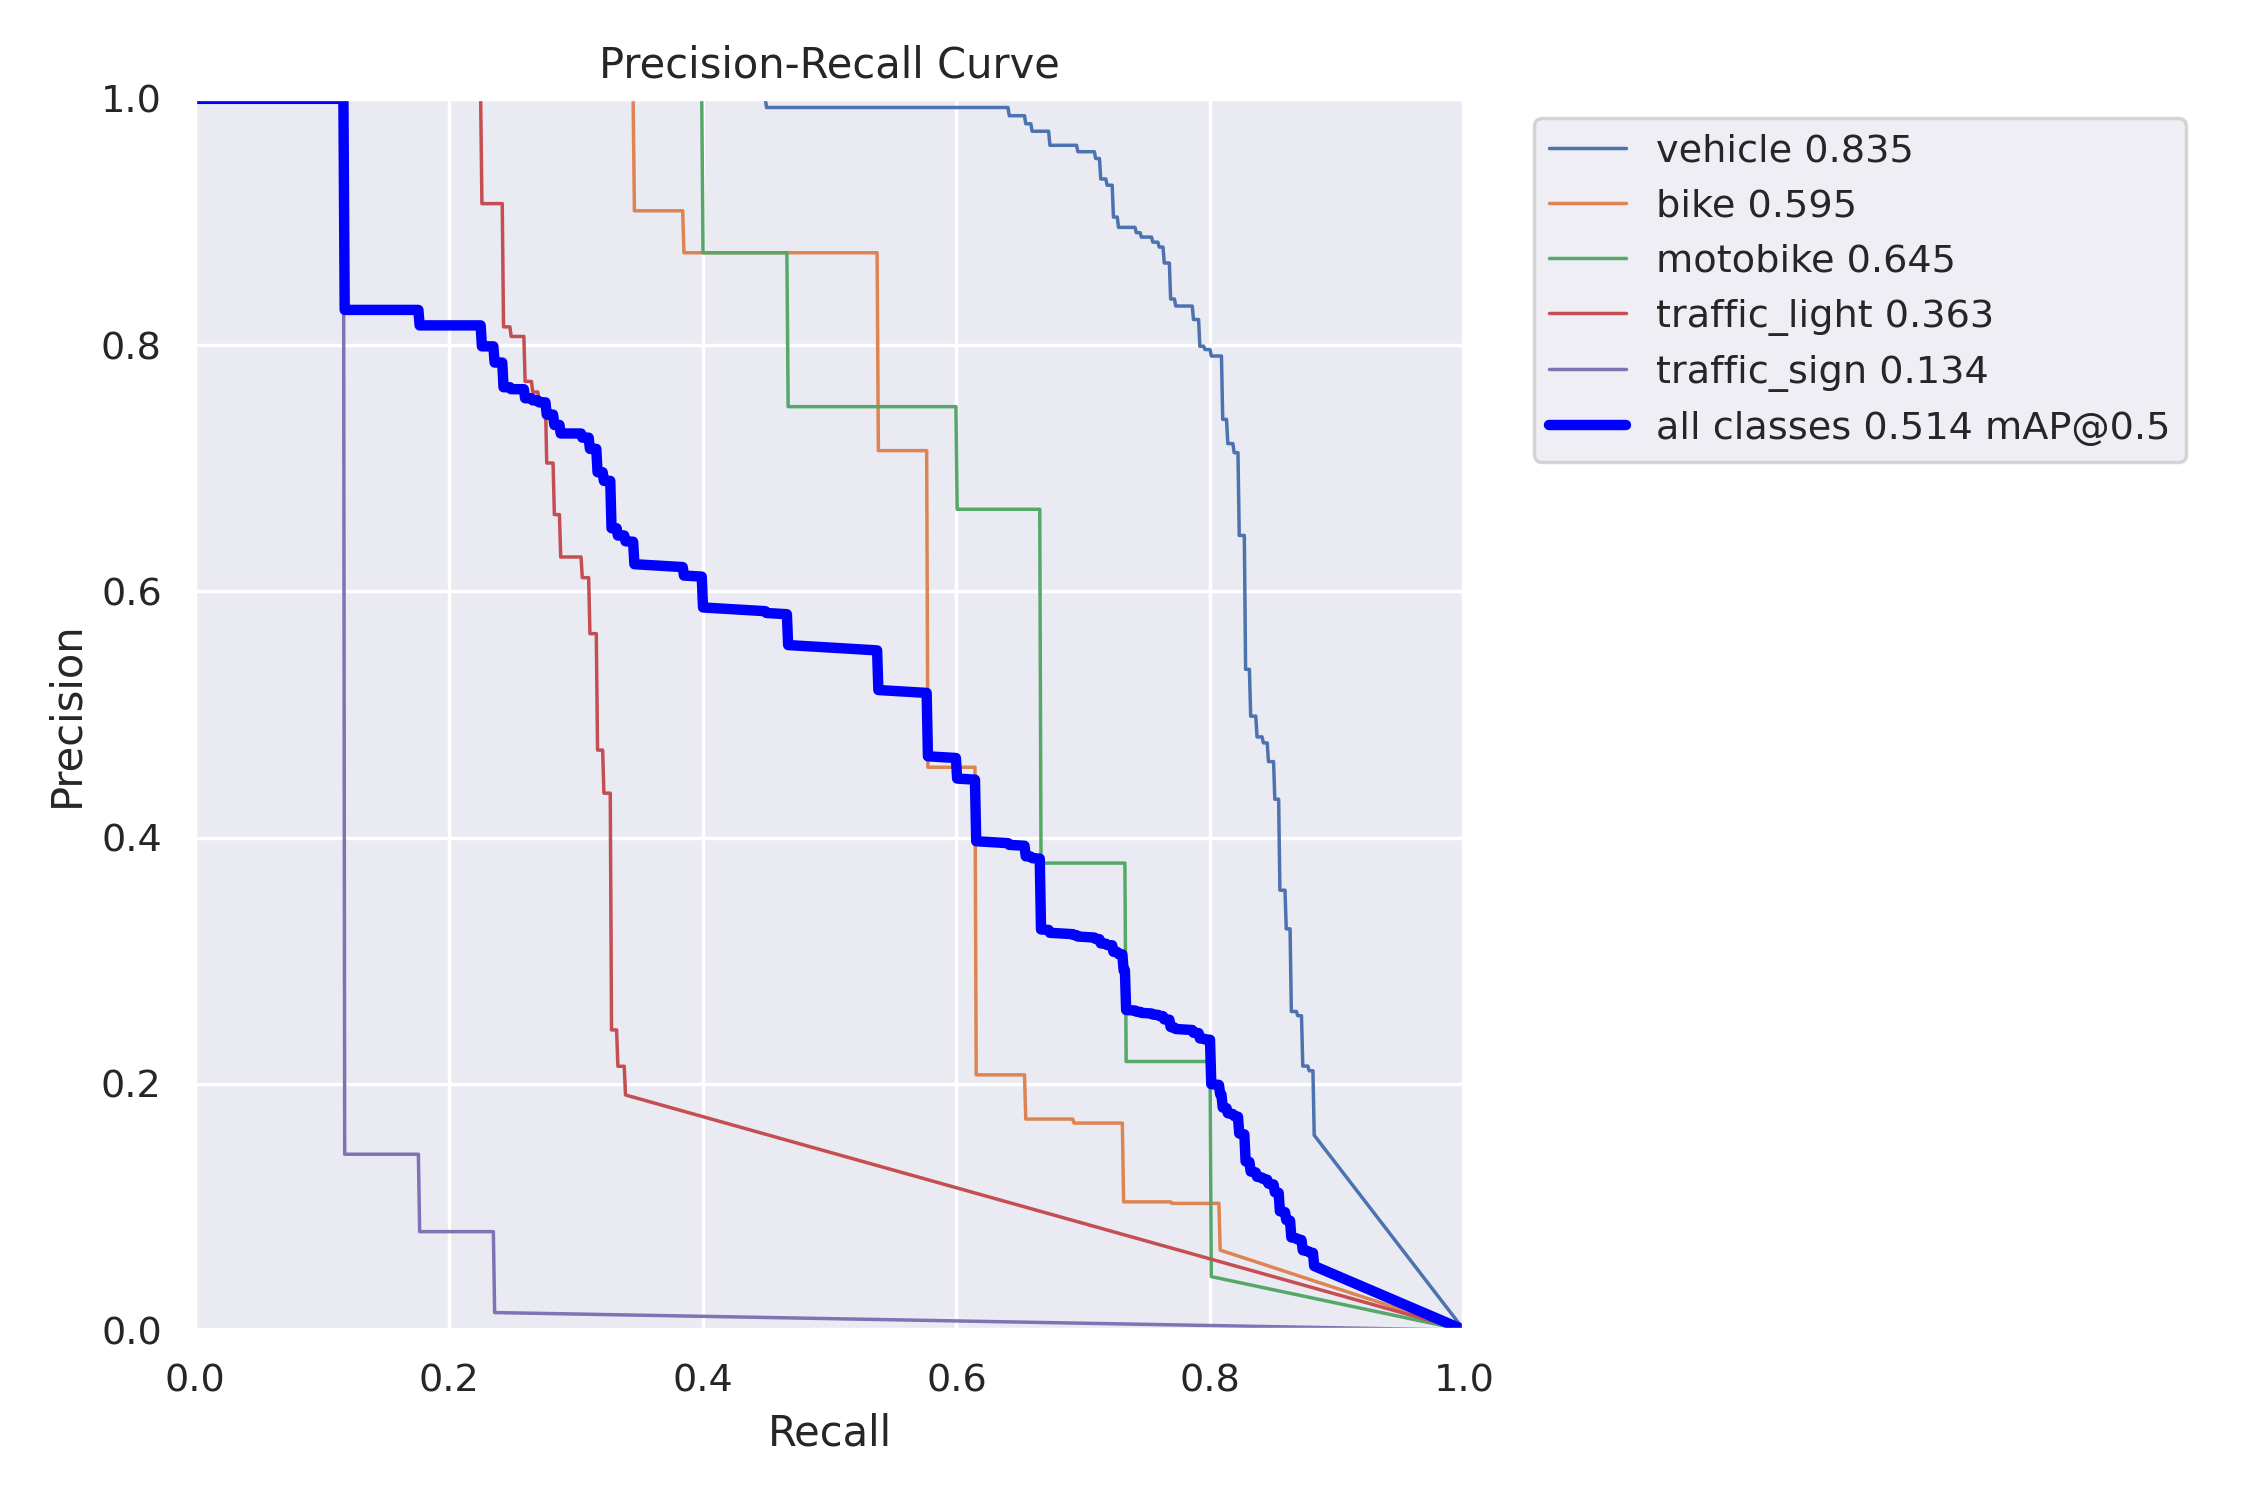

In [ ]:
Image(filename='/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/PR_curve.png', width=600)

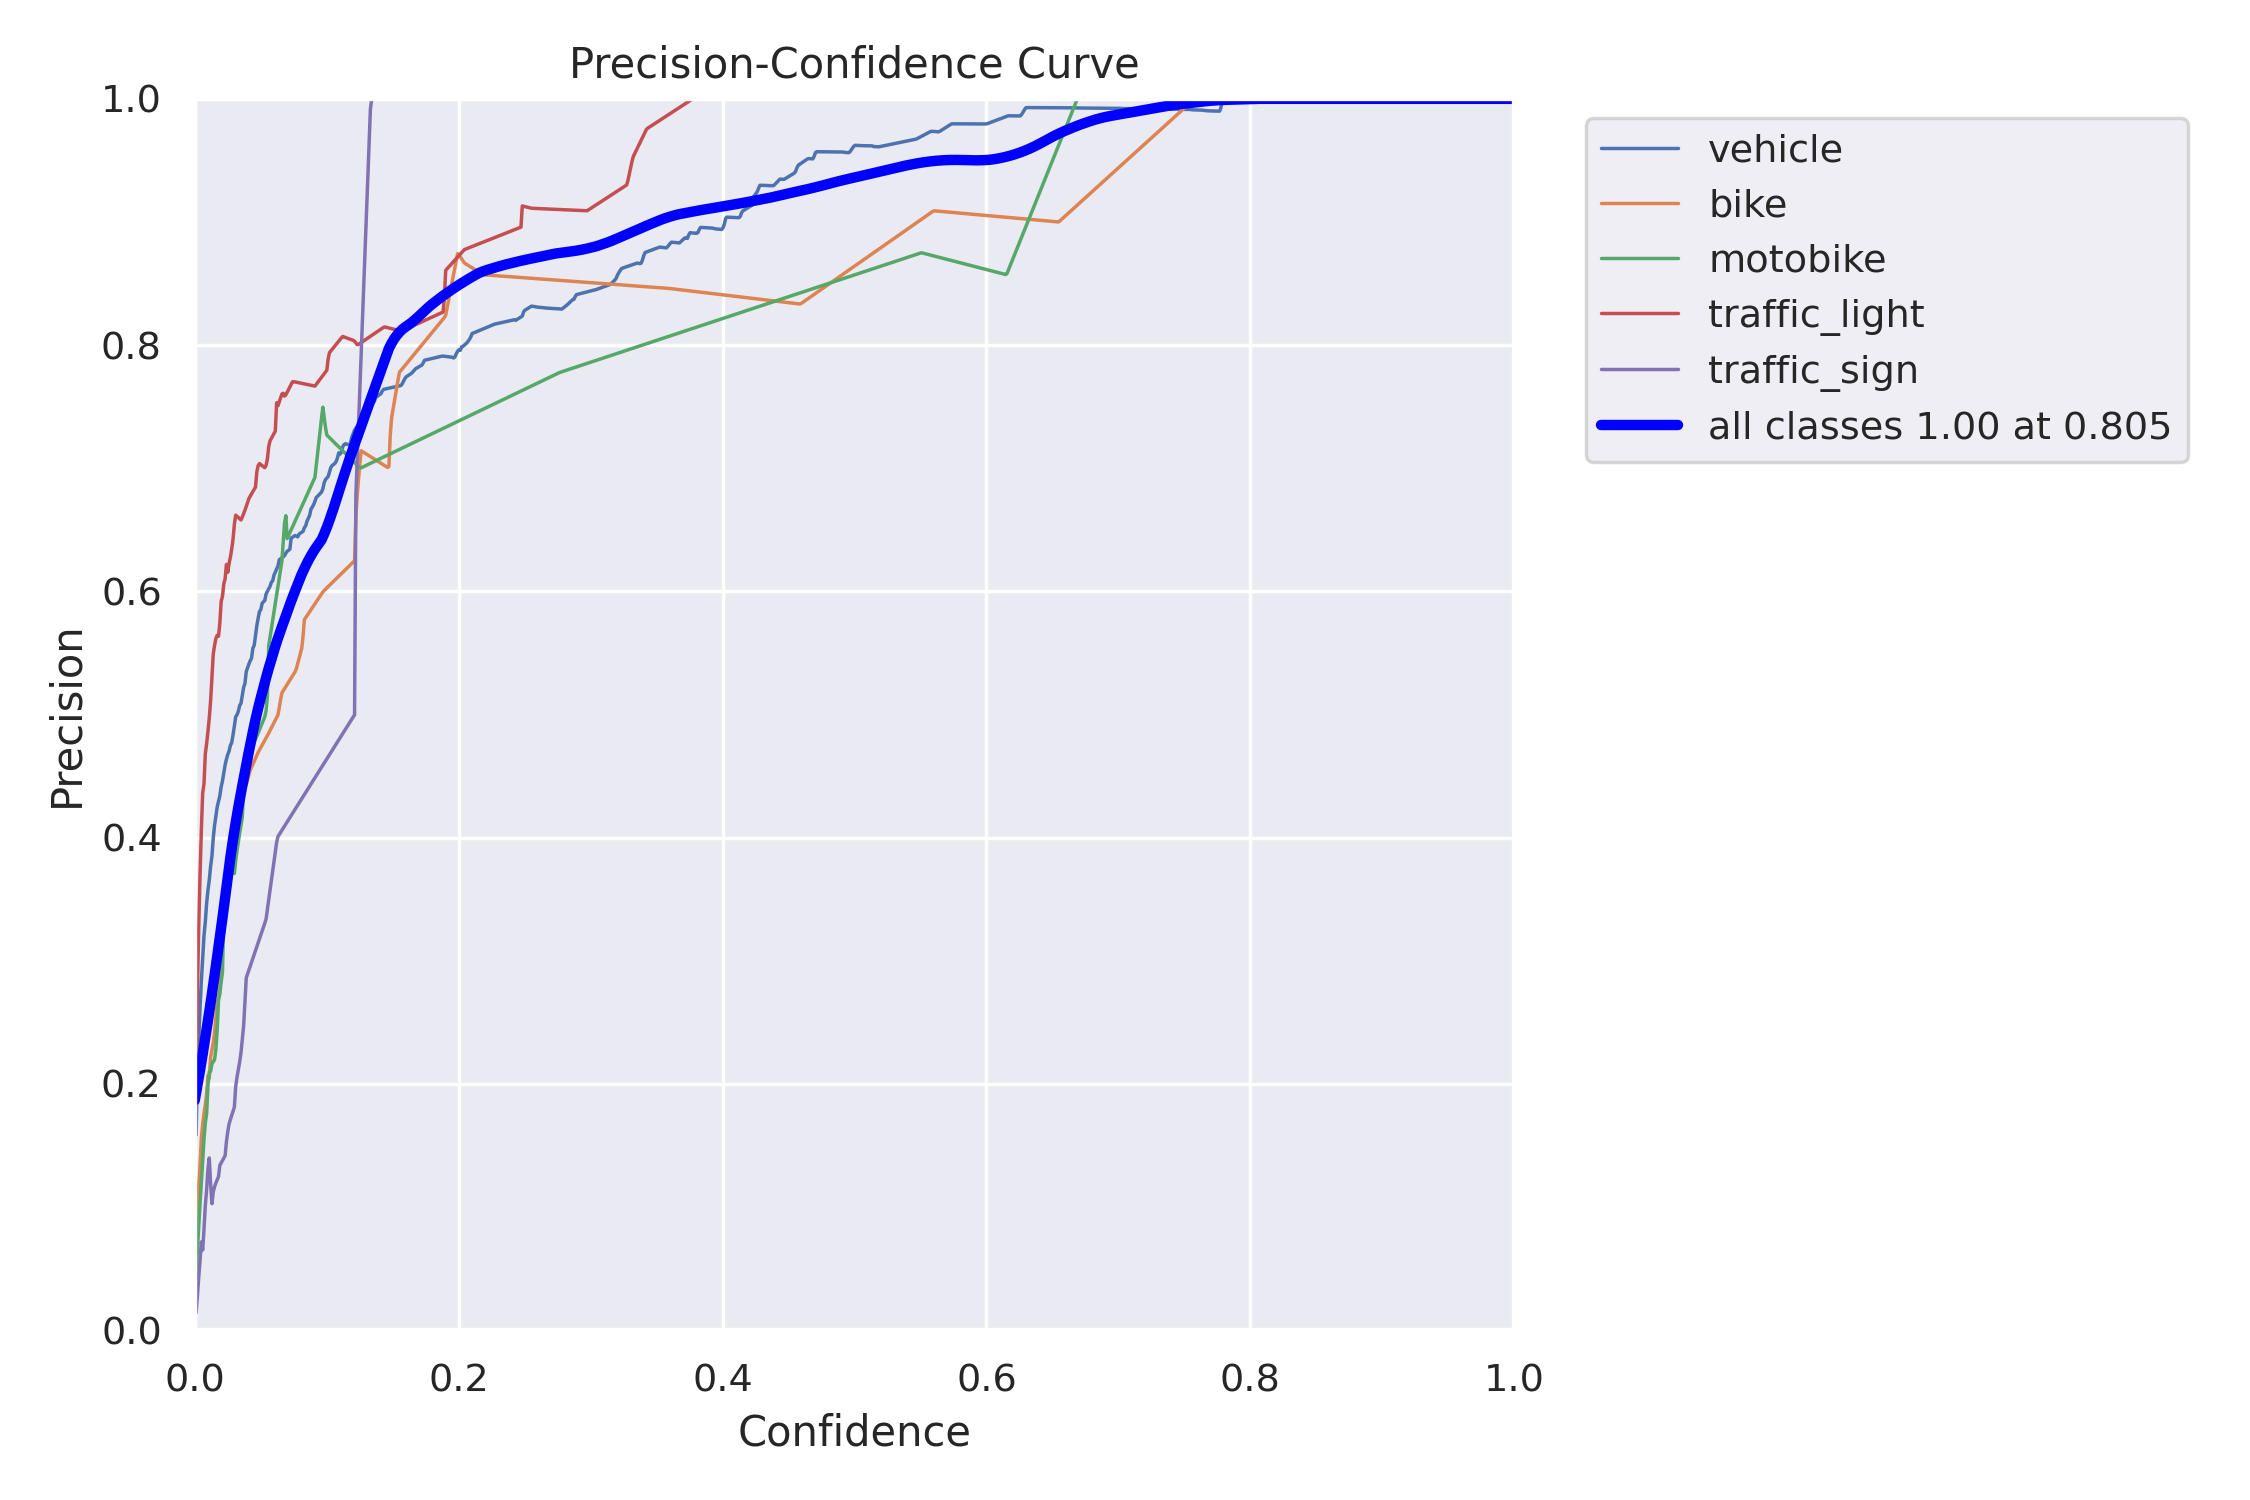

In [ ]:
Image(filename='/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/P_curve.png', width=600)

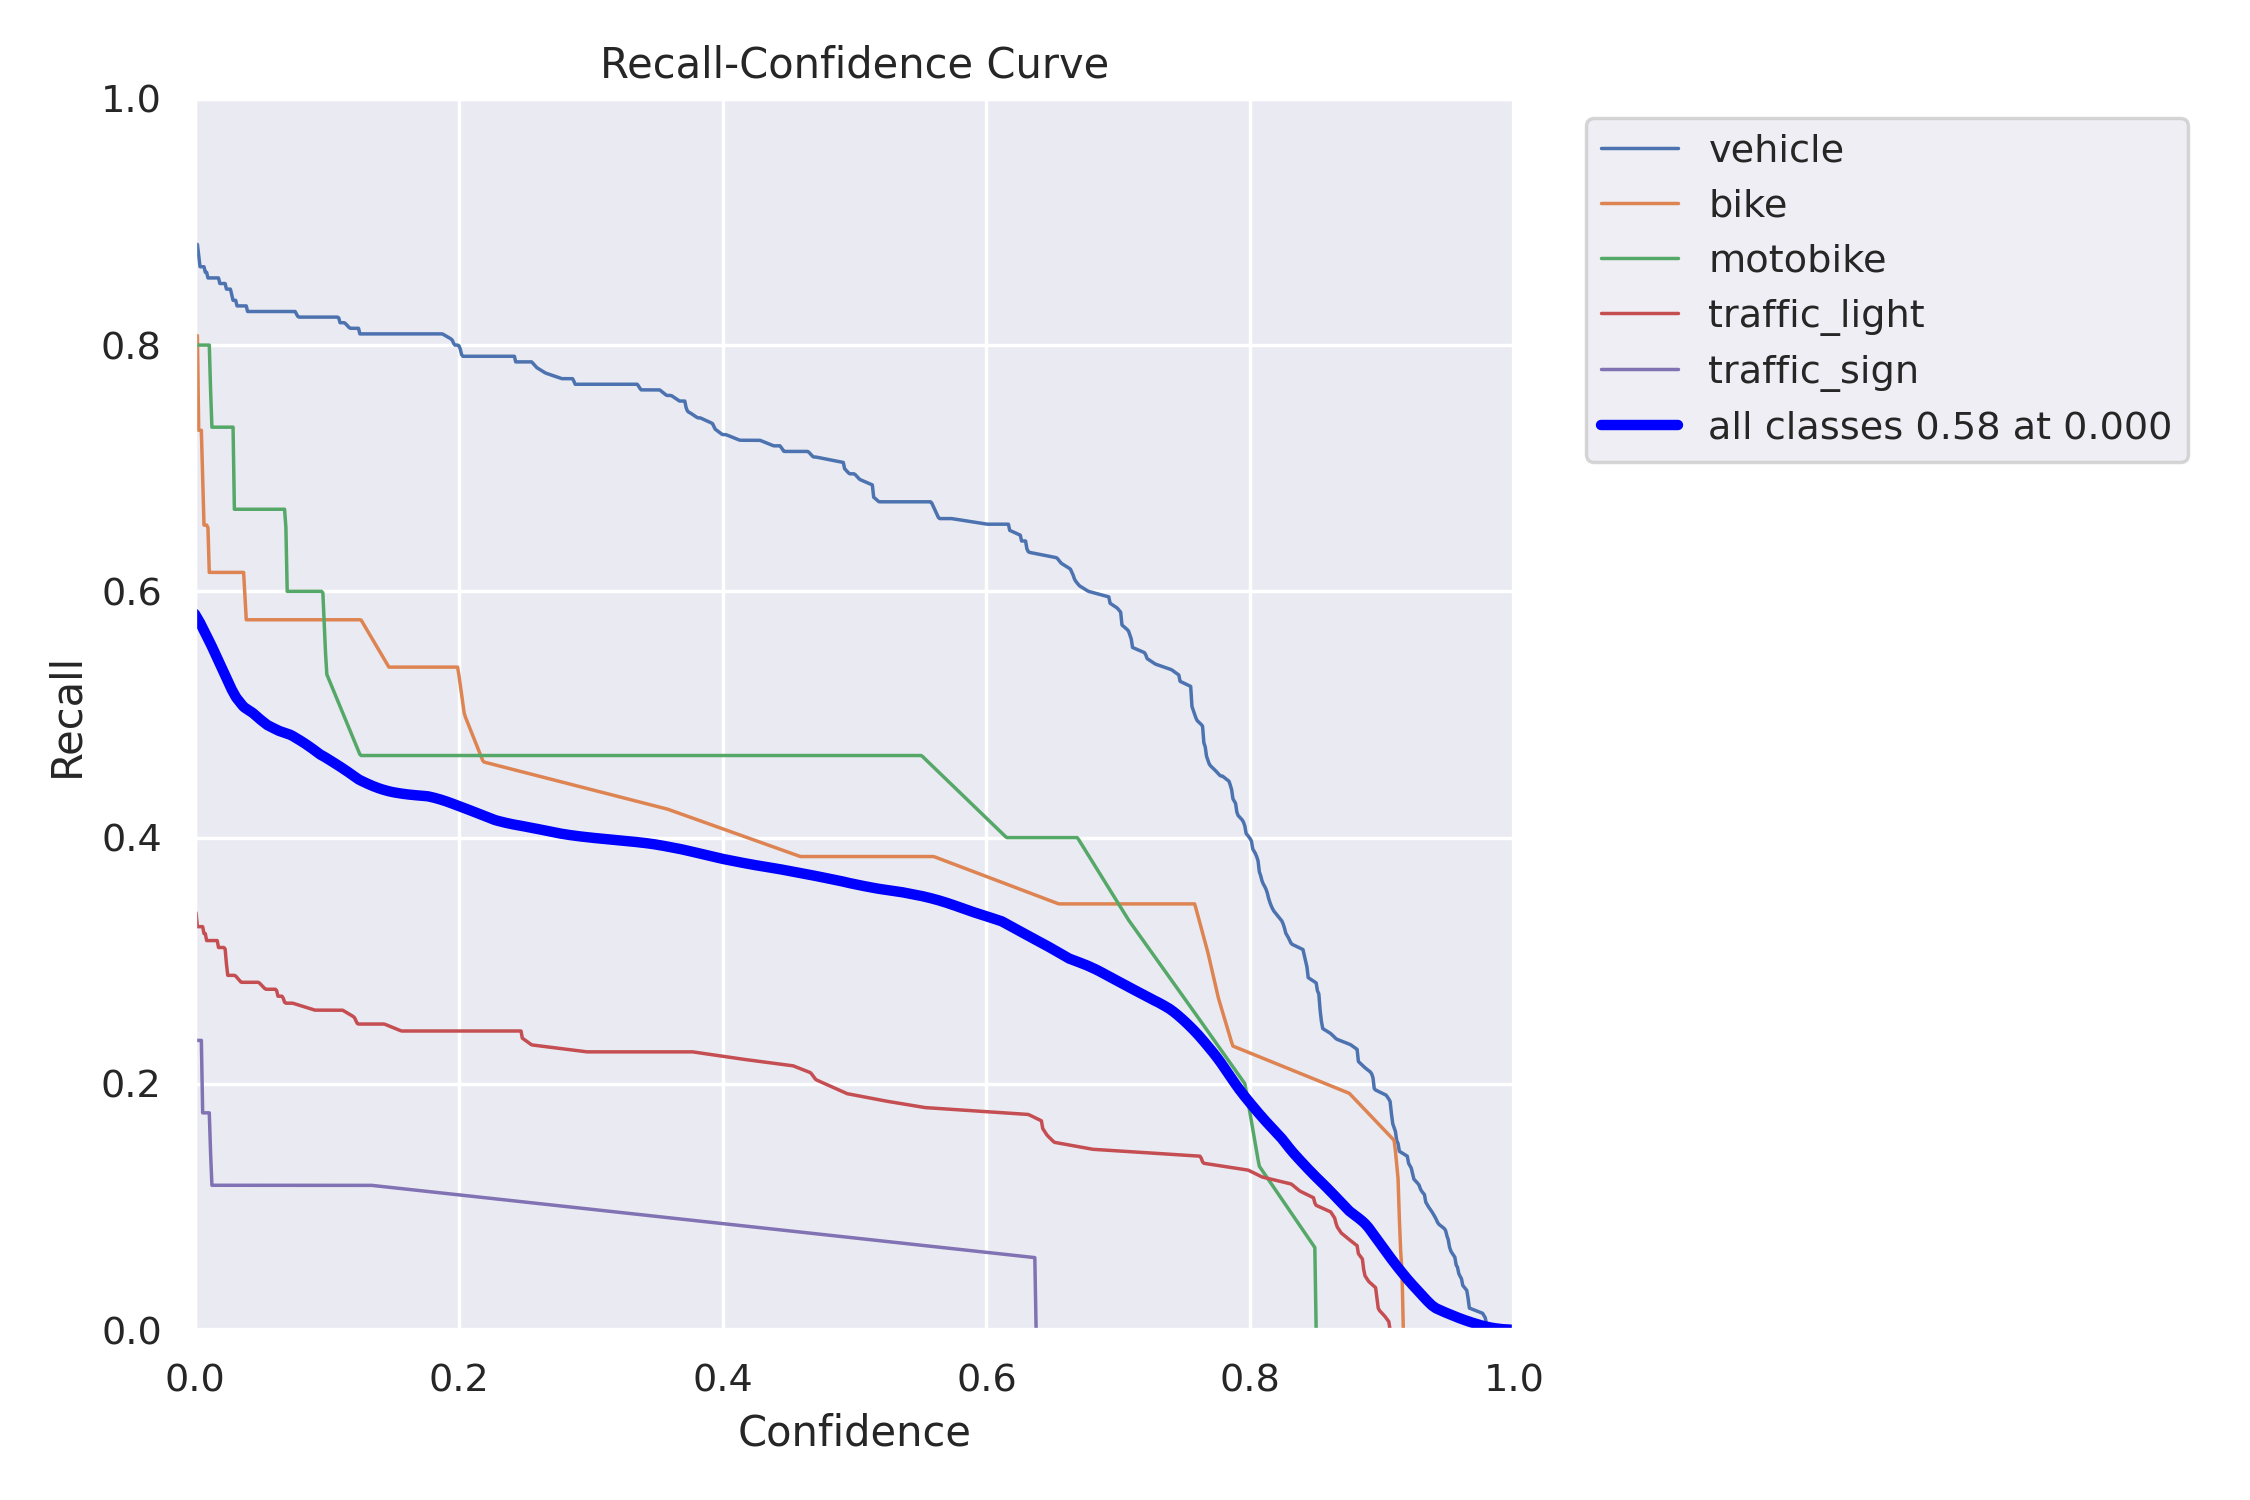

In [ ]:
Image(filename='/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/R_curve.png', width=600)

In [ ]:
data = pd.read_csv('/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/results.csv')
data

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),...,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.44550,2.45810,1.06260,0.66129,...,1.32050,0.97218,0.070811,0.003243,0.003243
1,1,1.22980,1.05370,0.95078,0.82207,...,1.06710,0.93248,0.040550,0.006316,0.006316
2,2,1.21680,0.91524,0.93247,0.80334,...,0.93044,0.93675,0.010026,0.009125,0.009125
3,3,1.24070,0.97499,0.94220,0.88112,...,1.11720,0.93144,0.008812,0.008812,0.008812
4,4,1.25180,0.84068,0.92185,0.80965,...,0.89773,0.95342,0.008812,0.008812,0.008812
5,5,1.25460,0.79598,0.92820,0.85280,...,0.82961,0.94791,0.008416,0.008416,0.008416
6,6,1.20370,0.77003,0.91520,0.84991,...,0.86396,0.95078,0.008020,0.008020,0.008020
7,7,1.21180,0.77871,0.92056,0.83513,...,0.76406,0.91106,0.007624,0.007624,0.007624
8,8,1.16190,0.74597,0.91006,0.82278,...,0.71846,0.92164,0.007228,0.007228,0.007228
9,9,1.13050,0.70987,0.90966,0.85435,...,0.71004,0.90723,0.006832,0.006832,0.006832


In [ ]:
!yolo task=detect mode=val model=/home/zeke/Downloads/part3_YOLO/runs/detect/train2/weights/best.pt data=/home/zeke/Downloads/part3_YOLO/data2.yaml

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11975MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /home/zeke/Downloads/part3_YOLO/val/labels.cache... 143 images, 15
                 Class     Images  Instances      Box(P          R      mAP50  mException in thread Thread-3 (plot_images):
Traceback (most recent call last):
  File "/home/zeke/anaconda3/envs/rapids/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/zeke/anaconda3/envs/rapids/lib/python3.10/site-packages/sentry_sdk/integrations/threading.py", line 72, in run
    reraise(*_capture_exception())
  File "/home/zeke/anaconda3/envs/rapids/lib/python3.10/site-packages/sentry_sdk/_compat.py", line 127, in reraise
    raise value
  File "/home/zeke/anaconda3/envs/rapids/lib/python3.10/site-packages/sentry_sdk/integrations/threading.py", line 70, in run
    return old_run_func(self, *a, **kw)
  Fi

In [ ]:
!yolo task=detect mode=predict model=/home/zeke/Downloads/part3_YOLO/runs/detect/train/weights/best.pt conf=0.25 source=/home/zeke/Downloads/part3_YOLO/test/images

Ultralytics YOLOv8.0.20 🚀 Python-3.10.13 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 11975MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs
image 1/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_001920.png: 160x224 48.0ms
image 2/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_001980.png: 160x224 2 vehicles, 1.9ms
image 3/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002040.png: 160x224 1 vehicle, 2.0ms
image 4/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002100.png: 160x224 1 vehicle, 1 traffic_light, 2.0ms
image 5/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002160.png: 160x224 1 vehicle, 1 traffic_light, 1.6ms
image 6/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002220.png: 160x224 1 vehicle, 1 traffic_light, 1.6ms
image 7/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002280.png: 160x224 1 traffic_light, 1.7ms
image 8/199 /home/zeke/Downloads/part3_YOLO/test/images/Town05_002340

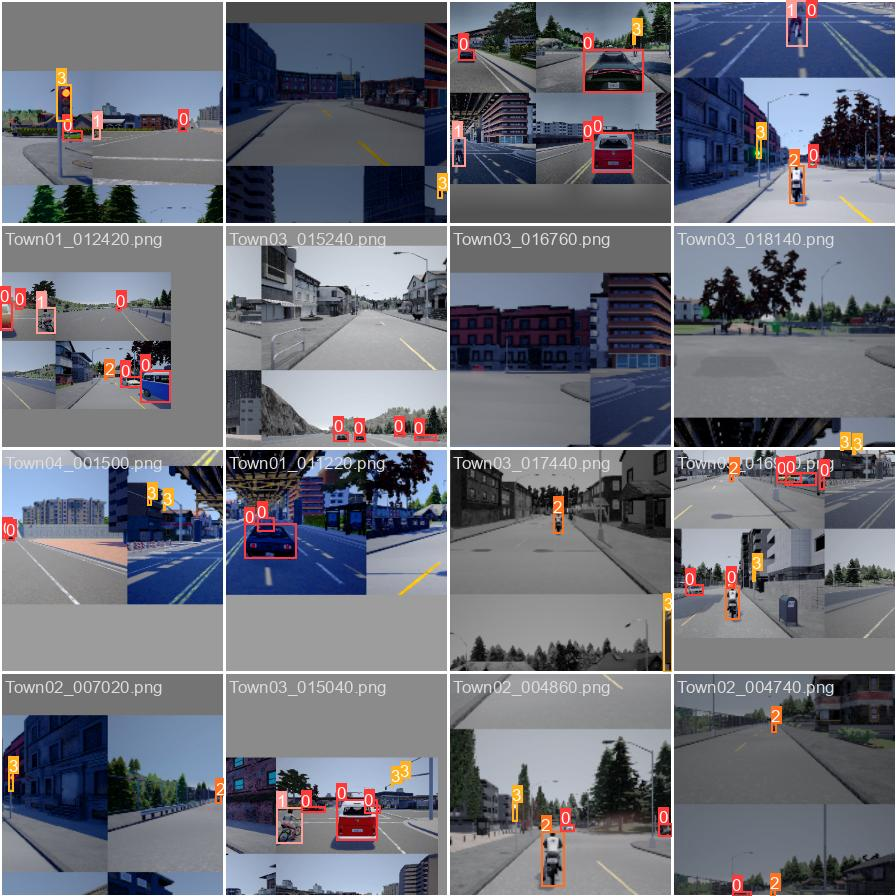

In [ ]:
Image(filename='/home/zeke/Downloads/images_yolo/runs/detect/train2/train_batch0.jpg', width=600)

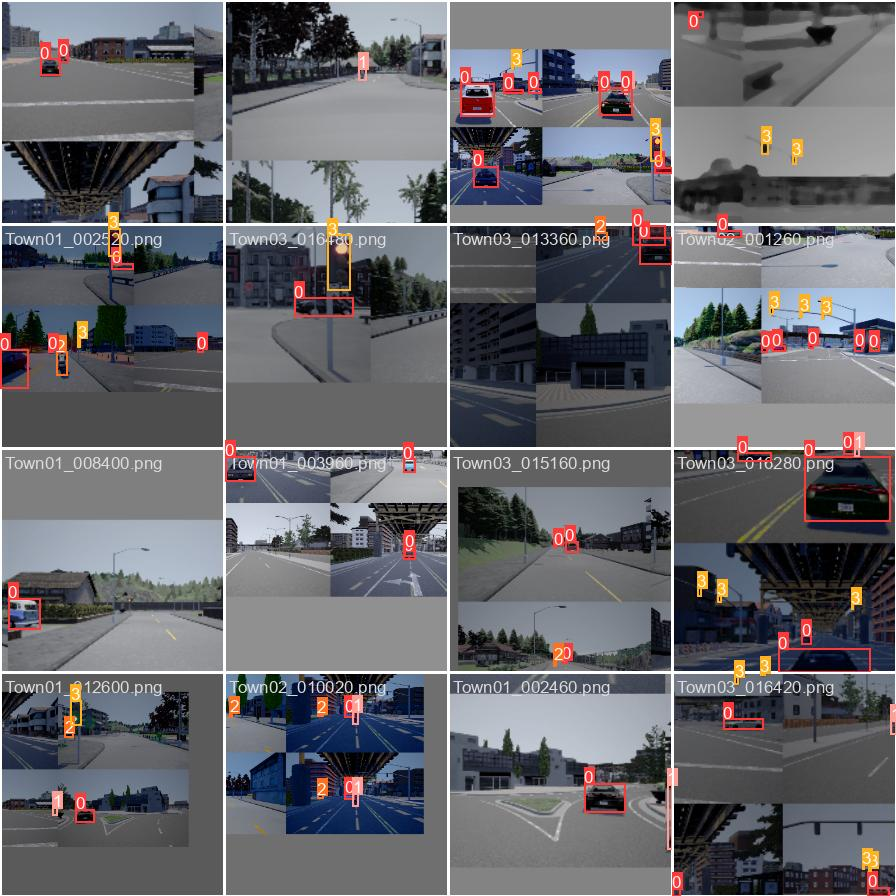

In [ ]:
Image(filename='/Users/jlonayang/Desktop/DATA_255/Lab1/runs/detect/train2/train_batch1.jpg', width=600)

In [ ]:
model=YOLO('/content/drive/Shareddrives/Data255_Lab/Lab1/Q3_part2_yolo/train2/weights/best.pt')
outs = model.predict(source="/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo/images_yolo/test/images", show=False)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


# IOU Calculation

In [ ]:
outs

[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([0, 6])
 dtype: torch.float32
  + tensor([], device='cuda:0', size=(0, 6)),
 Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([2, 6])
 dtype: torch.float32
  + tensor([[ 58.00000, 188.00000,  92.00000, 203.00000,   0.32086,   0.00000],
         [ 86.00000, 187.00000, 113.00000, 203.00000,   0.28997,   0.00000]], device='cuda:0'),
 Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([1, 6])
 dtype: torch.float32
  + tensor([[253.00000, 188.00000, 275.00000, 203.00000,   0.58186,   0.00000]], device='cuda:0'),
 Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([2, 6])
 dtype: torch.float32
  + tensor([[225.00000, 191.00000, 252.00000, 207.00000,   0.83220,   0.000

In [ ]:
def extract_predictions(outs):
    extracted_predictions = []
    for result in outs:
        boxes = result.boxes.xyxy.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy()

        for i, box in enumerate(boxes):
            extracted_predictions.append({
                'x1': box[0], 'y1': box[1],
                'x2': box[2], 'y2': box[3],
                'confidence': confidences[i],
                'class_id': class_ids[i]
            })
    return extracted_predictions

# Call the function with your YOLOv8 results
predictions = extract_predictions(outs)


In [ ]:
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height

# Example usage
image_path = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo/images_yolo/test/images/Town05_002280.png'
image_width, image_height = get_image_dimensions(image_path)
print(f"Image dimensions: {image_width}x{image_height}")


Image dimensions: 640x380


In [ ]:
def read_ground_truth(file_path):
    """
    Read ground truth bounding boxes from a file in YOLO format.
    """
    gt_boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id, x_center, y_center, width, height = map(float, parts[0:5])
            x1 = (x_center - width / 2)
            y1 = (y_center - height / 2)
            x2 = (x_center + width / 2)
            y2 = (y_center + height / 2)
            gt_boxes.append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'class_id': class_id})
    return gt_boxes

In [ ]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes defined by corner coordinates.
    """
    # Calculate intersection coordinates and area
    xi1 = max(pred_box['x1'], gt_box['x1'])
    yi1 = max(pred_box['y1'], gt_box['y1'])
    xi2 = min(pred_box['x2'], gt_box['x2'])
    yi2 = min(pred_box['y2'], gt_box['y2'])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Calculate union area
    pred_area = (pred_box['x2'] - pred_box['x1']) * (pred_box['y2'] - pred_box['y1'])
    gt_area = (gt_box['x2'] - gt_box['x1']) * (gt_box['y2'] - gt_box['y1'])
    union_area = pred_area + gt_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [ ]:
def normalize_predictions(predictions, image_width, image_height):
    """
    Normalize the bounding box coordinates of predictions to the range [0, 1].
    """
    normalized_predictions = []
    for pred in predictions:
        normalized = {
            'x1': pred['x1'] / image_width,
            'y1': pred['y1'] / image_height,
            'x2': pred['x2'] / image_width,
            'y2': pred['y2'] / image_height,
            'confidence': pred['confidence'],
            'class_id': pred['class_id']
        }
        normalized_predictions.append(normalized)
    return normalized_predictions

In [ ]:
def calculate_iou_for_classes(gt_dir, predictions, image_width, image_height):
    """
    Normalize predictions, then iterate over ground truth files and calculate IoU by class.
    """
    # Normalize predictions to [0, 1] range
    normalized_predictions = normalize_predictions(predictions, image_width, image_height)

    iou_by_class = {i: [] for i in range(5)}  # Assuming class IDs 0 through 4

    for filename in os.listdir(gt_dir):
        gt_path = os.path.join(gt_dir, filename)
        gt_boxes = read_ground_truth(gt_path)

        for gt in gt_boxes:
            for pred in normalized_predictions:
                if gt['class_id'] == pred['class_id']:
                    iou = calculate_iou(pred, gt)
                    iou_by_class[gt['class_id']].append(iou)

    # Calculate and print average IoU for each class
    for class_id, ious in iou_by_class.items():
        avg_iou = sum(ious) / len(ious) if ious else 0
        print(f"Class {class_id} average IoU: {avg_iou:.4f}")

In [ ]:
image_width = 640
image_height = 380
gt_dir = '/content/drive/Shareddrives/Data255_Lab/Lab1/yolov8_dataset/yolo/images_yolo/test/labels'
calculate_iou_for_classes(gt_dir, predictions, image_width, image_height)

Class 0 average IoU: 0.0542
Class 1 average IoU: 0.1700
Class 2 average IoU: 0.0981
Class 3 average IoU: 0.0078
Class 4 average IoU: 0.0000
